# TPS September using TFDF
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/kaggle_intermediate_example_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/kaggle_intermediate_example_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/kaggle_intermediate_example_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/kaggle_intermediate_example_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


Kaggle dataset - [Tabular Playground Series - Sep 2021](https://www.kaggle.com/c/tabular-playground-series-sep-2021)

# Configuration

To run this notebook, you need to have a Kaggle account.

If you do not have an account, create one here: [Kaggle Register](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F) 

Read through the [Authentication Section](https://www.kaggle.com/docs/api#authentication) of the Kaggle API documentation to get a key for the following section.

In [1]:
#@title Enter your Kaggle token in order to fetch the dataset

username = '' #@param {type:"string"}
key = '' #@param {type: "string"}

In [ ]:
#@title Configure Kaggle
try:
  from google.colab import files, drive

  # Install and Configure Kaggle
  import json

  token = {
    "username":username,
    "key":key
  }

  # Installing kaggle
  !pip install kaggle &> /dev/null

  # Creating .kaggle if necessary
  !if [ -d .kaggle ]; then echo ".kaggle exists"; else echo ".kaggle does not exist ... Creating it"; mkdir .kaggle; if [ -d .kaggle ]; then echo "Successfully created"; else echo "Error creating .kaggle"; fi; fi

  with open('/content/.kaggle/kaggle.json', 'w') as file:
      json.dump(token, file)

  # Creating .kaggle if necessary
  !if [ -d  ~/.kaggle ]; then echo " ~/.kaggle exists"; else echo " ~/.kaggle does not exist ... Creating it"; mkdir  ~/.kaggle; if [ -d  ~/.kaggle ]; then echo "Successfully created"; else echo "Error creating  ~/.kaggle"; fi; fi
  !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

  # kaggle configuration
  !kaggle config set -n path -v{/content}

  # Changing mode
  !chmod 600 /root/.kaggle/kaggle.json
except Exception:
  pass

In [ ]:
#@title Download Dataset
import os

DOWNLOAD_LOCATION = "/root/Downloads/"

if os.path.exists(DOWNLOAD_LOCATION):
    if os.path.isdir(DOWNLOAD_LOCATION):
        print("{} exists and is a directory".format(DOWNLOAD_LOCATION))
    else:
        print("{} exists but is not a directory!!!".format(DOWNLOAD_LOCATION))
else:
    print("{} does not exist ... Creating it".format(DOWNLOAD_LOCATION))
    os.makedirs(DOWNLOAD_LOCATION)

# Downloading
!kaggle competitions download -c tabular-playground-series-sep-2021 -p {DOWNLOAD_LOCATION}

# Extracting archives
!cd {DOWNLOAD_LOCATION}; unzip -qq \*.zip; rm -f *.zip

In [ ]:
#@title Install TensorFlow Decision Forests
!pip install tensorflow_decision_forests -U -q

In [5]:
#@title User Input Configuration

rnd_seed =  42#@param {type:"number"}
validation_ratio = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}

## Import

In [6]:
#@title
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from tensorflow import keras

import matplotlib.pyplot as plt

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

print("TensorFlow Version: {}".format(tf.__version__))
print("TensorFlow Decision Forests: {}".format(tfdf.__version__))

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

np.random.seed(rnd_seed)
tf.random.set_seed(rnd_seed)

VALID_RATIO = validation_ratio

TensorFlow Version: 2.9.1
TensorFlow Decision Forests: 0.2.7


# Data Loading

In [7]:
train_file_path = os.path.join(DOWNLOAD_LOCATION, "train.csv")
train_full_data = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(train_full_data.shape))

Full train dataset shape is (957919, 120)


In [8]:
train_full_data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


The data is composed of 120 columns all of which are numerical:
* 118 feature columns named `f1, f2, ... f118`
* label column named `claim`
* An `id` column that we will drop

In [9]:
train_full_data = train_full_data.drop('id', axis=1)
features = [f'f{i}' for i in range(1, 119)]
label = 'claim'

Let's check if we have missing data

In [10]:
train_full_data[features].isna().sum()

f1      15247
f2      15190
f3      15491
f4      15560
f5      15405
        ...  
f114    15438
f115    15559
f116    15589
f117    15407
f118    15212
Length: 118, dtype: int64

We can see that the data contains a lot of missing values. Approximately 15000 for each feature. That's around 1.5%

The approach we will take in this notebook is to keep missing values, but add 3 additional features:
* `Number of missing values` in each sample
    * For each sample out of the 957919, we will see how many values are missing across all features and then include this as a new feature. 
    * If there were n features missing, we will record the number n. 
* `Standard deviation` over axis=1
    * Standard deviation for each sample.
* `Unbiased Variance` over axis=1
    * Variance for each sample.

This preprocessing, and feature addition, will be implemented through the 2 methods mentioned previously. 
1. Preprocessing using pandas
2. Tensorflow based Preprocessing

Let's start with the first one.

In [11]:
def split_dataset(dataset, test_ratio=0.1):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

# First Approach: Preprocessing using pandas

## Preprocessing

In the approach that we will use in this notebook, we will keep the missing values but will add 3 additional features:

In [12]:
train_full_data['nan'] = train_full_data[features].isnull().sum(axis=1)
train_full_data['std'] = train_full_data[features].std(axis=1)
train_full_data['var'] = train_full_data[features].var(axis=1)

## Datasets

Split the dataframe into training and validation sets

In [13]:
train_ds_pd, valid_ds_pd = split_dataset(train_full_data, test_ratio=VALID_RATIO)
print("{} samples in training and {} in validation".format(train_ds_pd.shape[0], valid_ds_pd.shape[0]))

862229 samples in training and 95690 in validation


Create the training and validation datasets using TensorFlow Decision Forests `pd_dataframe_to_tf_dataset`

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

## GradientBoostedTreesModel Training

For hyperparameter tuning, we did the following:
* Tried the predefined hyperparameters which did not give good results 
    * Especially `benchmark_rank1` which gave very bad results not to mention that it takes longer time to fit the data. 
    * `better_default` on the other hand gave acceptable results.
* Used Keras tuner in order to search for hyperparameters that maximise `AUC`. 
    * If you want to check how to do this, check out the following Kaggle [notebook](https://www.kaggle.com/ekaterinadranitsyna/kerastuner-tf-decision-forest?linkId=133421702) by Ekaterina Dranitsyna.

Finally the hyperparameters that gave the best results where the below which are `better_default` with `l1_regularization`

In [ ]:
model_1 = tfdf.keras.GradientBoostedTreesModel(
    growing_strategy = 'BEST_FIRST_GLOBAL',
    l1_regularization = 0.8
)

model_1.compile(metrics=[keras.metrics.AUC()])

The next cell will take some time to get executed.


In [16]:
%set_cell_height 300
model_1.fit(train_ds, verbose=2)

<IPython.core.display.Javascript object>

Reading training dataset...
Training tensor examples:
Features: {'f1': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'f2': <tf.Tensor 'data_30:0' shape=(None,) dtype=float64>, 'f3': <tf.Tensor 'data_41:0' shape=(None,) dtype=float64>, 'f4': <tf.Tensor 'data_52:0' shape=(None,) dtype=float64>, 'f5': <tf.Tensor 'data_63:0' shape=(None,) dtype=float64>, 'f6': <tf.Tensor 'data_74:0' shape=(None,) dtype=float64>, 'f7': <tf.Tensor 'data_85:0' shape=(None,) dtype=float64>, 'f8': <tf.Tensor 'data_96:0' shape=(None,) dtype=float64>, 'f9': <tf.Tensor 'data_107:0' shape=(None,) dtype=float64>, 'f10': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'f11': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, 'f12': <tf.Tensor 'data_22:0' shape=(None,) dtype=float64>, 'f13': <tf.Tensor 'data_23:0' shape=(None,) dtype=float64>, 'f14': <tf.Tensor 'data_24:0' shape=(None,) dtype=float64>, 'f15': <tf.Tensor 'data_25:0' shape=(None,) dtype=float64>, 'f16': <tf.Tensor 'data_26:0' shape=(None,) dty

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 863
[INFO kernel.cc:423] Number of examples: 862229
[INFO kernel.cc:836] Training dataset:
Number of records: 862229
Number of columns: 122

Number of columns by type:
	NUMERICAL: 121 (99.1803%)
	CATEGORICAL: 1 (0.819672%)

Columns:

NUMERICAL: 121 (99.1803%)
	0: "f1" NUMERICAL num-nas:13707 (1.58972%) mean:0.0901929 min:-0.14991 max:0.41517 sd:0.0435975
	1: "f10" NUMERICAL num-nas:13738 (1.59331%) mean:5323.89 min:-26404 max:85622 sd:10071.6
	2: "f100" NUMERICAL num-nas:13925 (1.615%) mean:0.425797 min:-0.034559 max:1.0613 sd:0.283504
	3: "f101" NUMERICAL num-nas:13822 (1.60305%) mean:20.2106 min:-4.2949 max:105.62 sd:19.6196
	4: "f102" NUMERICAL num-nas:13631 (1.5809%) mean:321610 min:-227770 max:2.3379e+06 sd:327719
	5: "f103" NUMERICAL num-nas:14039 (1.62822%) mean:548.513 min:-222.21 max:3260.9 sd:864.005
	6: "f104" NUMERICAL num-nas:13696 (1.5

Model trained in 2:55:37.440718
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Post Training Analysis

`model.summary()` shows us the overall structure of the model

In [17]:
%set_cell_height 300

model_1.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (121):
	f1
	f10
	f100
	f101
	f102
	f103
	f104
	f105
	f106
	f107
	f108
	f109
	f11
	f110
	f111
	f112
	f113
	f114
	f115
	f116
	f117
	f118
	f12
	f13
	f14
	f15
	f16
	f17
	f18
	f19
	f2
	f20
	f21
	f22
	f23
	f24
	f25
	f26
	f27
	f28
	f29
	f3
	f30
	f31
	f32
	f33
	f34
	f35
	f36
	f37
	f38
	f39
	f4
	f40
	f41
	f42
	f43
	f44
	f45
	f46
	f47
	f48
	f49
	f5
	f50
	f51
	f52
	f53
	f54
	f55
	f56
	f57
	f58
	f59
	f6
	f60
	f61
	f62
	f63
	f64
	f65
	f66
	f67
	f68
	f69
	f7
	f70
	f71
	f72
	f73
	f74
	f75
	f76
	f77
	f78
	f79
	f8
	f80
	f81
	f82
	f83
	f84
	f85
	f86
	f87
	f88
	f89
	f9
	f90
	f91
	f92
	f93
	f94
	f95
	f96
	f97
	f98
	f99
	nan
	std
	v

We can access all this information using the model inspector

In [18]:
inspector = model_1.make_inspector()

In [19]:
print("Model contains {} trees".format(inspector.num_trees()))

Model contains 300 trees


In [20]:
%set_cell_height 300

inspector.features()

<IPython.core.display.Javascript object>

["f1" (1; #0),
 "f10" (1; #1),
 "f100" (1; #2),
 "f101" (1; #3),
 "f102" (1; #4),
 "f103" (1; #5),
 "f104" (1; #6),
 "f105" (1; #7),
 "f106" (1; #8),
 "f107" (1; #9),
 "f108" (1; #10),
 "f109" (1; #11),
 "f11" (1; #12),
 "f110" (1; #13),
 "f111" (1; #14),
 "f112" (1; #15),
 "f113" (1; #16),
 "f114" (1; #17),
 "f115" (1; #18),
 "f116" (1; #19),
 "f117" (1; #20),
 "f118" (1; #21),
 "f12" (1; #22),
 "f13" (1; #23),
 "f14" (1; #24),
 "f15" (1; #25),
 "f16" (1; #26),
 "f17" (1; #27),
 "f18" (1; #28),
 "f19" (1; #29),
 "f2" (1; #30),
 "f20" (1; #31),
 "f21" (1; #32),
 "f22" (1; #33),
 "f23" (1; #34),
 "f24" (1; #35),
 "f25" (1; #36),
 "f26" (1; #37),
 "f27" (1; #38),
 "f28" (1; #39),
 "f29" (1; #40),
 "f3" (1; #41),
 "f30" (1; #42),
 "f31" (1; #43),
 "f32" (1; #44),
 "f33" (1; #45),
 "f34" (1; #46),
 "f35" (1; #47),
 "f36" (1; #48),
 "f37" (1; #49),
 "f38" (1; #50),
 "f39" (1; #51),
 "f4" (1; #52),
 "f40" (1; #53),
 "f41" (1; #54),
 "f42" (1; #55),
 "f43" (1; #56),
 "f44" (1; #57),
 "f45" (1

In [21]:
%set_cell_height 300

inspector.variable_importances()

<IPython.core.display.Javascript object>

{'NUM_AS_ROOT': [("nan" (1; #118), 53.0),
  ("f40" (1; #53), 9.0),
  ("f70" (1; #86), 9.0),
  ("f1" (1; #0), 8.0),
  ("f25" (1; #36), 8.0),
  ("f28" (1; #39), 8.0),
  ("f11" (1; #12), 7.0),
  ("f24" (1; #35), 7.0),
  ("f47" (1; #60), 7.0),
  ("f65" (1; #80), 7.0),
  ("f102" (1; #4), 6.0),
  ("f2" (1; #30), 6.0),
  ("f21" (1; #32), 6.0),
  ("f8" (1; #96), 6.0),
  ("f32" (1; #44), 5.0),
  ("f37" (1; #49), 5.0),
  ("f45" (1; #58), 5.0),
  ("f106" (1; #8), 4.0),
  ("f107" (1; #9), 4.0),
  ("f113" (1; #16), 4.0),
  ("f16" (1; #26), 4.0),
  ("f35" (1; #47), 4.0),
  ("f57" (1; #71), 4.0),
  ("f67" (1; #82), 4.0),
  ("f92" (1; #110), 4.0),
  ("f95" (1; #113), 4.0),
  ("f99" (1; #117), 4.0),
  ("f111" (1; #14), 3.0),
  ("f114" (1; #17), 3.0),
  ("f23" (1; #34), 3.0),
  ("f29" (1; #40), 3.0),
  ("f34" (1; #46), 3.0),
  ("f36" (1; #48), 3.0),
  ("f39" (1; #51), 3.0),
  ("f5" (1; #63), 3.0),
  ("f50" (1; #64), 3.0),
  ("f6" (1; #74), 3.0),
  ("f61" (1; #76), 3.0),
  ("f71" (1; #87), 3.0),
  ("f75"

Let's plot a tiny part of the model

In [22]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

### Training Logs

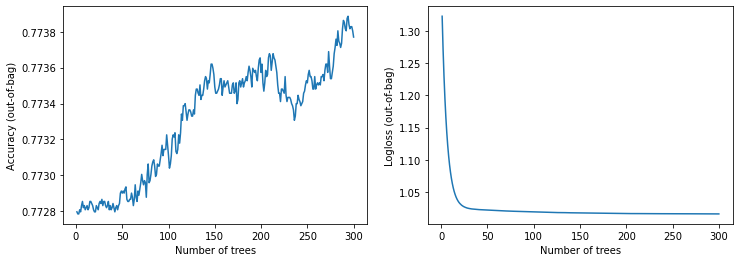

In [23]:
logs = inspector.training_logs()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('Accuracy (out-of-bag)')
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('Logloss (out-of-bag)')
plt.show()

## Evaluation

Let's evaluate the model using the validation dataset

In [24]:
evaluation = model_1.evaluate(valid_ds, return_dict = True)
for name, value in evaluation.items():
    print("{}: {}".format(name, value))

96/96 [==============================] - 12s 109ms/step - loss: 0.0000e+00 - auc: 0.8129
loss: 0.0
auc: 0.8128870725631714


Let's now look at our second approach

# Second Approach: TensorFlow based preprocessing

In this second approach, we will not add the 3 columns that we added using pandas but rather through TensorFlow / Keras preprocessing that we will pass to the model via the preprocessing parameter.

You will notice that this approach is more difficult, more complicated, however it has the advantage of having the preprocessing within the model itself.

In [46]:
train_full_data = pd.read_csv(train_file_path)

In [47]:
train_full_data = train_full_data.drop('id', axis=1)
features = [f'f{i}' for i in range(1, 119)]
label = 'claim'

## Datasets

In [48]:
train_ds_pd, valid_ds_pd = split_dataset(train_full_data, test_ratio=VALID_RATIO)
print("{} samples in training and {} in validation".format(train_ds_pd.shape[0], valid_ds_pd.shape[0]))

862073 samples in training and 95846 in validation


In [49]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

## Preprocessing

In [50]:
def reduce_mean_without_nan(input_tensor):
    return tf.experimental.numpy.nanmean(input_tensor, axis=1, keepdims=True)

def get_nan_std_var(input_tensor):
    # nan tensor
    is_nan = tf.math.is_nan(input_tensor)
    
    # Get the number of nans available in each sample
    nan_number_per_sample = tf.cast(
        tf.math.reduce_sum(
            tf.where(is_nan, [1], [0]),
            axis=1,
            keepdims=True
        ),
        tf.float32
    )
    
    # Calculate mean excluding nan
    mean_excluding_nan = keras.layers.Lambda(reduce_mean_without_nan)(input_tensor)
    
    # input tensor replacing nan with the mean for each row (i.e. for each sample)
    input_tensor_with_nan_replaced_by_mean = tf.where(
        is_nan,
        mean_excluding_nan,
        input_tensor
    )
    
    squared_distance_from_mean = tf.math.reduce_sum(
        tf.math.square(
            input_tensor_with_nan_replaced_by_mean - mean_excluding_nan,
        ),
        axis=1,
        keepdims=True
    )
    
    # Calculate std
    std = tf.math.sqrt(
        tf.math.divide(
            squared_distance_from_mean,
            input_tensor.shape[1] - nan_number_per_sample,
        )
    )
    
    # Calculate var
    var = tf.math.divide(
        squared_distance_from_mean,
        input_tensor.shape[1] - nan_number_per_sample - 1,
    )
    
    stack =tf.stack([nan_number_per_sample, std, var], axis=1)
    
    return tf.squeeze(stack, axis=-1)

In [51]:
%set_cell_height 300

def build_preprocessing_model(features):
    # Create inputs
    input_layers = []

    # Each feature will be one input
    for feature in features:
        input_layers.append(keras.layers.Input(shape=(1,), name=feature))
    
    # Concatenate all inputs
    inputs = keras.layers.concatenate(input_layers, name="inputs")
        
    
    # Add 3 additional features:
    # - How many nan are they in each sample
    # - std accross the features of each sample
    # - var accross the features of each sample
    additional_features = get_nan_std_var(inputs)
    
    outputs = keras.layers.concatenate([inputs, additional_features])
    
    return keras.Model(input_layers, outputs)

preprocessing_model = build_preprocessing_model(features)
preprocessing_model.summary()

<IPython.core.display.Javascript object>

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 f1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 f2 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 f3 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 f4 (InputLayer)                [(None, 1)]          0           []                               
                                                                                            

## GradientBoostedTreesModel Training

In [52]:
model_2 = tfdf.keras.GradientBoostedTreesModel(
    growing_strategy = 'BEST_FIRST_GLOBAL',
    l1_regularization = 0.6,
    preprocessing = preprocessing_model
)

model_2.compile(metrics=[keras.metrics.AUC()])

Use /tmp/tmp9b_jj2ix as temporary training directory


The next cell will take some time to get executed.

In [53]:
%set_cell_height 300
model_2.fit(train_ds, verbose=2)

<IPython.core.display.Javascript object>

Reading training dataset...
Training tensor examples:
Features: {'f1': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'f2': <tf.Tensor 'data_30:0' shape=(None,) dtype=float64>, 'f3': <tf.Tensor 'data_41:0' shape=(None,) dtype=float64>, 'f4': <tf.Tensor 'data_52:0' shape=(None,) dtype=float64>, 'f5': <tf.Tensor 'data_63:0' shape=(None,) dtype=float64>, 'f6': <tf.Tensor 'data_74:0' shape=(None,) dtype=float64>, 'f7': <tf.Tensor 'data_85:0' shape=(None,) dtype=float64>, 'f8': <tf.Tensor 'data_96:0' shape=(None,) dtype=float64>, 'f9': <tf.Tensor 'data_107:0' shape=(None,) dtype=float64>, 'f10': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'f11': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, 'f12': <tf.Tensor 'data_22:0' shape=(None,) dtype=float64>, 'f13': <tf.Tensor 'data_23:0' shape=(None,) dtype=float64>, 'f14': <tf.Tensor 'data_24:0' shape=(None,) dtype=float64>, 'f15': <tf.Tensor 'data_25:0' shape=(None,) dtype=float64>, 'f16': <tf.Tensor 'data_26:0' shape=(None,) dty

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 863
[INFO kernel.cc:423] Number of examples: 862073
[INFO kernel.cc:836] Training dataset:
Number of records: 862073
Number of columns: 122

Number of columns by type:
	NUMERICAL: 121 (99.1803%)
	CATEGORICAL: 1 (0.819672%)

Columns:

NUMERICAL: 121 (99.1803%)
	0: "model_1/concatenate_1/concat:0.0" NUMERICAL num-nas:13713 (1.5907%) mean:0.090203 min:-0.14991 max:0.41517 sd:0.0435705
	1: "model_1/concatenate_1/concat:0.1" NUMERICAL num-nas:13645 (1.58281%) mean:0.345976 min:-0.019044 max:0.51899 sd:0.146234
	2: "model_1/concatenate_1/concat:0.10" NUMERICAL num-nas:13869 (1.6088%) mean:0.729908 min:-8.0863 max:8.6505 sd:1.49508
	3: "model_1/concatenate_1/concat:0.100" NUMERICAL num-nas:13841 (1.60555%) mean:20.2062 min:-4.2949 max:105.62 sd:19.612
	4: "model_1/concatenate_1/concat:0.101" NUMERICAL num-nas:13661 (1.58467%) mean:321655 min:-227770 max:2.

Model trained in 2:59:00.140120
Compiling model...
Model compiled.


## Post Training Analysis

`model.summary()` shows us the overall structure of the model

In [54]:
%set_cell_height 300

model_2.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 121)               0         
                                                                 
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (121):
	model_1/concatenate_1/concat:0.0
	model_1/concatenate_1/concat:0.1
	model_1/concatenate_1/concat:0.10
	model_1/concatenate_1/concat:0.100
	model_1/concatenate_1/concat:0.101
	model_1/concatenate_1/concat:0.102
	model_1/concatenate_1/concat:0.103
	model_1/concatenate_1/concat:0.104
	model_1/concatenate_1/concat:0.105
	model_1/concatenate_1/concat:0.106
	model_1/concatenate_1/concat:0.107
	model_1/concatenate_1/concat:0.108
	model_1/concatenate_1/concat:0.109
	model_1/concat

In [56]:
inspector = model_2.make_inspector()

In [57]:
print("Model contains {} trees".format(inspector.num_trees()))

Model contains 279 trees


In [58]:
%set_cell_height 300

inspector.features()

<IPython.core.display.Javascript object>

["model_1/concatenate_1/concat:0.0" (1; #0),
 "model_1/concatenate_1/concat:0.1" (1; #1),
 "model_1/concatenate_1/concat:0.10" (1; #2),
 "model_1/concatenate_1/concat:0.100" (1; #3),
 "model_1/concatenate_1/concat:0.101" (1; #4),
 "model_1/concatenate_1/concat:0.102" (1; #5),
 "model_1/concatenate_1/concat:0.103" (1; #6),
 "model_1/concatenate_1/concat:0.104" (1; #7),
 "model_1/concatenate_1/concat:0.105" (1; #8),
 "model_1/concatenate_1/concat:0.106" (1; #9),
 "model_1/concatenate_1/concat:0.107" (1; #10),
 "model_1/concatenate_1/concat:0.108" (1; #11),
 "model_1/concatenate_1/concat:0.109" (1; #12),
 "model_1/concatenate_1/concat:0.11" (1; #13),
 "model_1/concatenate_1/concat:0.110" (1; #14),
 "model_1/concatenate_1/concat:0.111" (1; #15),
 "model_1/concatenate_1/concat:0.112" (1; #16),
 "model_1/concatenate_1/concat:0.113" (1; #17),
 "model_1/concatenate_1/concat:0.114" (1; #18),
 "model_1/concatenate_1/concat:0.115" (1; #19),
 "model_1/concatenate_1/concat:0.116" (1; #20),
 "model_

In [59]:
%set_cell_height 300

inspector.variable_importances()

<IPython.core.display.Javascript object>

{'NUM_NODES': [("model_1/concatenate_1/concat:0.39" (1; #54), 219.0),
  ("model_1/concatenate_1/concat:0.118" (1; #22), 167.0),
  ("model_1/concatenate_1/concat:0.69" (1; #87), 146.0),
  ("model_1/concatenate_1/concat:0.46" (1; #62), 143.0),
  ("model_1/concatenate_1/concat:0.44" (1; #60), 127.0),
  ("model_1/concatenate_1/concat:0.20" (1; #34), 124.0),
  ("model_1/concatenate_1/concat:0.33" (1; #48), 121.0),
  ("model_1/concatenate_1/concat:0.34" (1; #49), 116.0),
  ("model_1/concatenate_1/concat:0.0" (1; #0), 115.0),
  ("model_1/concatenate_1/concat:0.51" (1; #68), 110.0),
  ("model_1/concatenate_1/concat:0.56" (1; #73), 110.0),
  ("model_1/concatenate_1/concat:0.64" (1; #82), 106.0),
  ("model_1/concatenate_1/concat:0.76" (1; #95), 106.0),
  ("model_1/concatenate_1/concat:0.106" (1; #9), 103.0),
  ("model_1/concatenate_1/concat:0.7" (1; #88), 103.0),
  ("model_1/concatenate_1/concat:0.27" (1; #41), 101.0),
  ("model_1/concatenate_1/concat:0.95" (1; #116), 100.0),
  ("model_1/concate

In [60]:
tfdf.model_plotter.plot_model_in_colab(model_2, tree_idx=0, max_depth=3)

### Training Logs

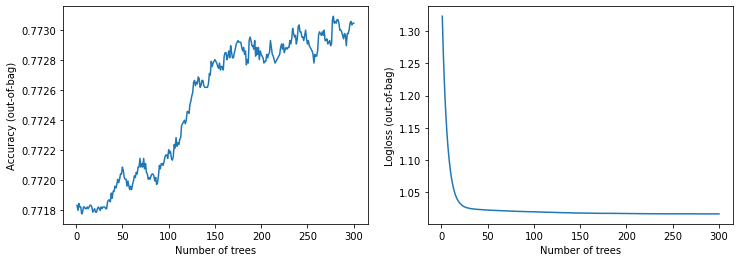

In [61]:
logs = inspector.training_logs()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('Accuracy (out-of-bag)')
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('Logloss (out-of-bag)')
plt.show()

## Evaluation

Let's evaluate the model using the validation dataset

In [62]:
evaluation = model_2.evaluate(valid_ds, return_dict = True)
for name, value in evaluation.items():
    print("{}: {}".format(name, value))

96/96 [==============================] - 16s 131ms/step - loss: 0.0000e+00 - auc_2: 0.8150
loss: 0.0
auc_2: 0.8149550557136536


This model as you noticed created the additional features differently. While the pandas based method counts the nan values and calculates std and var on the whole training dataset, this model calculates and counts them for each batch.

# Test Set Prediction

Although the [Tabular Playground Series - Sep 2021](https://www.kaggle.com/c/tabular-playground-series-sep-2021) has officially ended, you can still perform a Late Submission and compare the results with others on the leaderboard, especially if you want to tweak the notebook and apply some changes.



In [63]:
#@title Select which model to use for prediction

model = model_1 #@param ["model_1", "model_2"] {type: "raw"}

if model == model_1:
    print("model_1")
else:
    print("model_2")


model_1


In [64]:
test_file_path = os.path.join(DOWNLOAD_LOCATION, "test.csv")
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('id')

In [65]:
if model == model_1:
    test_data['nan'] = test_data[features].isnull().sum(axis=1)
    test_data['std'] = test_data[features].std(axis=1)
    test_data['var'] = test_data[features].var(axis=1)

In [66]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data)

In [67]:
preds = model.predict(test_ds)

494/494 [==============================] - 60s 119ms/step


In [68]:
output = pd.DataFrame({'id': ids,
                       'claim': preds.squeeze()})

output.head()

,id,claim
0,957919,0.630406
1,957920,0.115652
2,957921,0.620445
3,957922,0.120009
4,957923,0.137160


In [69]:
output_filename = "test_prediction_output.csv"
output.to_csv(output_filename, index=False)

In [70]:
from google.colab import files
files.download('test_prediction_output.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References


*   [KerasTuner + TF Decision Forest](https://www.kaggle.com/ekaterinadranitsyna/kerastuner-tf-decision-forest?linkId=133421702) by [Ekaterina Dranitsyna](https://www.kaggle.com/ekaterinadranitsyna)
*   [TensorFlow Decision Forests tutorials](https://www.tensorflow.org/decision_forests/tutorials) which are a set of 3 very interesting (beginner, intermediate and advanced levels) tutorials.
*   The [TensorFlow Forum](https://discuss.tensorflow.org/) where one can get in touch with the TensorFlow community. Check it out if you haven't yet.

